In [2]:
import shelve
import mkl_random as rnd
from tqdm import trange,tqdm
from numba import jit
import itertools
is_ordinal = lambda x : True if "ordinal__" in x else False
is_nominal = lambda x : True if "nominal__" in x else False
is_binary = lambda x : True if "binary__" in x else False
is_interval = lambda x : True if "interval__" in x else False
import pandas as pd
pd.options.compute.use_numba = False
import itertools
import math

from pgmpy.models import BayesianModel,BayesianNetwork,MarkovModel,NaiveBayes
from pgmpy.estimators import BayesianEstimator,ExhaustiveSearch,PC,HillClimbSearch,MaximumLikelihoodEstimator ,BicScore


from mysetup import NotebookFinder
import sys

sys.meta_path.append(NotebookFinder())

from setup_work import *
from msiit_db import MyDB
db = MyDB()

nominal = [x for x in db.eval_data.columns if "nominal_" in x]
ordinal = [x for x in db.eval_data.columns if "ordinal_" in x]
binary = [x for x in db.eval_data.columns if "binary_" in x]
interval = [x for x in db.eval_data.columns if "interval_" in x]
data_groups = [nominal,ordinal,binary,interval]

def gen_col_data(df):
    idx = df.index.to_flat_index().to_list()
    col_names = [f'col_{i}' for i in range(7)]
    df = pd.DataFrame(columns=col_names)
    for j,i_ in enumerate(idx):
        for k,c in zip(i_,col_names):
            df.loc[j,c] =k
    return df
orig_columns = ['binary__offer_expiration',
 'ordinal__income_range',
 'ordinal__no_visited_cold_drinks',
 'binary__travelled_more_than_15mins_for_offer',
 'ordinal__restaur_spend_less_than20',
 'nominal__marital_status',
 'nominal__restaurant_type',
 'ordinal__age',
 'binary__prefer_western_over_chinese',
 'binary__travelled_more_than_25mins_for_offer',
 'ordinal__no_visited_bars',
 'binary__gender',
 'nominal__car',
 'binary__restuarant_same_direction_house',
 'binary__cooks_regularly',
 'nominal__customer_type',
 'ordinal__qualif',
 'binary__is_foodie',
 'ordinal__no_take_aways',
 'nominal__job_industry',
 'binary__restuarant_opposite_direction_house',
 'binary__has_children',
 'ordinal__type_of_rest_rating',
 'interval__temperature',
 'ordinal__restaur_spend_greater_than20',
 'interval__travel_time',
 'interval__season',
 'ordinal__dest_distance',
 'binary__prefer_home_food',
 ]

master_X = pd.concat([db.data[db.eval_data.columns],db.eval_data],ignore_index=True,axis=0).astype(np.uint16)
enc = OrdinalEncoder()
enc.fit(master_X.loc[:,ordinal])
db.data[ordinal] = enc.transform(db.data[ordinal]).astype(np.uint16)
db.eval_data[ordinal] = enc.transform(db.eval_data.loc[:,ordinal]).astype(np.uint16)
db.nr_data[db.nr_eval_data.columns] = db.data[db.nr_eval_data.columns].astype(np.uint16)
db.nr_eval_data = db.eval_data[db.nr_eval_data.columns].astype(np.uint16)
master_X = pd.concat([db.data[db.eval_data.columns],db.eval_data],ignore_index=True,axis=0).astype(np.uint16)
pd.options.compute.use_numba=False

In [4]:
X = db.data
list(db.data.columns)
'nominal__pref_profile', 'nominal__biz_type', 'nominal__spend_id', 'nominal__direction', 'nominal__extra_travel', 'nominal__circumstance'

('nominal__pref_profile',
 'nominal__biz_type',
 'nominal__spend_id',
 'nominal__direction',
 'nominal__extra_travel',
 'nominal__circumstance')

In [2]:
data_dictionary={
    'binary__offer_expiration': 'Number of days offer is valid',
    'ordinal__income_range': 'income range',
    'ordinal__no_visited_cold_drinks': 'Number of times visited cold drinks',
    'binary__travelled_more_than_15mins_for_offer': 'Have you traveled more than 15 mins to avail an offer?',
    'ordinal__restaur_spend_less_than20': 'Number of times spend less than 20 dollar in restaurant',
    'nominal__marital_status': 'Marital status',
    'nominal__restaurant_type': 'type of restaurant',
    'ordinal__age': 'age',
    'binary__prefer_western_over_chinese': 'Do you Prefer western over chinese',
    'binary__travelled_more_than_25mins_for_offer': 'Have you traveled more than 25 mins to avail an offer?',
    'ordinal__no_visited_bars': 'Number of times visited bar',
    'binary__gender': 'gender',
    'nominal__car': 'type of vehicle do you use in your own words',
    'binary__restuarant_same_direction_house': 'is the coupon offered restaurant located same direction to your house?',
    'binary__cooks_regularly': 'Do you cook regularly?',
    'nominal__customer_type': 'Whom do you prefer to go with?',
    'ordinal__qualif': 'Qualification',
    'binary__is_foodie': 'Is foodie',
    
    'ordinal__no_take_aways': 'Number of times opted for take-away',
    'nominal__job_industry': 'Type of industry you work with',
    'binary__restuarant_opposite_direction_house': 'is the coupon offered restaurant located opposite direction to your house?',
    'binary__has_children': 'Do you have children?',
    'ordinal__type_of_rest_rating': 'average rating of the restaurant which gave offer',
    'interval__temperature': 'current temperature',
    'ordinal__restaur_spend_greater_than20': 'Number of times spend greater than 20 dollar in restuarant',
    'interval__travel_time': 'travel time for the restaurant which gave offer',
    'interval__season': 'current climate',
    'ordinal__dest_distance': 'where are you heading to?',
    'binary__prefer_home_food': 'Do you prefer home food?',
    'target': ' Did you accept the offer?'
}


target    200
dtype: int64

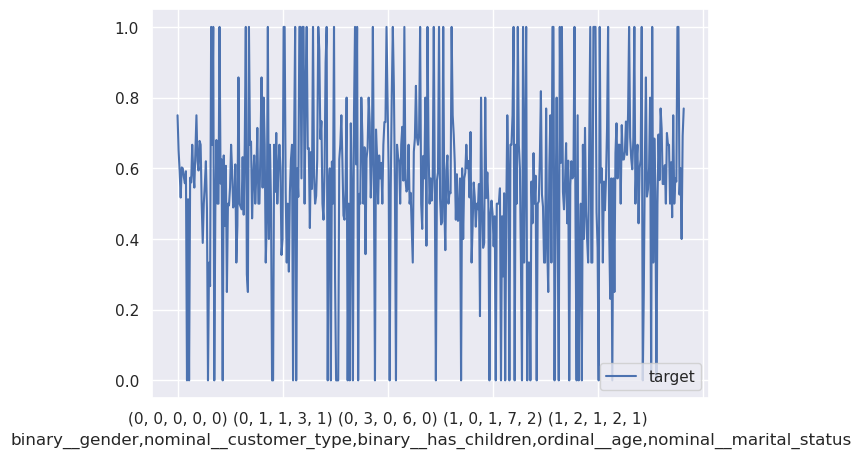

In [16]:
import random
A_ = ['binary__gender','ordinal__age','nominal__marital_status','binary__has_children','nominal__customer_type']
# A = ['binary__gender','ordinal__age','nominal__marital_status']
B = ['target']
collec = list(itertools.permutations(A_))
A = list(random.choice(collec))
stat =  X.groupby(A)[B].sum()/X.groupby(A)[B].count()
stat2 =  X.groupby(A)[B].count()/X.shape[0]
X_eval = db.eval_data.copy()
X_eval['dummy'] = 1
stat3 =  X_eval.groupby(A)['dummy'].count()/X_eval.shape[0]

# stat2 = stat2*100
# stat2.sort_values(ascending=False,inplace=True)
# ddo = stat2.index
# stat = stat.loc[stat2.index]


# stat2.plot(logy=False, label='gen_pop')
stat.plot(logy=False,label='target')
# stat3.plot(label='eval')
_ = plt.legend()
(stat>0.6).sum()

In [122]:
# model = BayesianModel()
# model.fit(db.data[A], estimator=BayesianEstimator)
from pgmpy.estimators import TreeSearch
X = db.data[db.orig_columns+['target']].copy()
# X = db.data.copy()
cols = list(X.columns)
rem_d_usco = lambda x : x.replace("__","_")
new_cols = list(map(rem_d_usco,cols))
r_c = {x:x_new for x, x_new in zip(cols,new_cols)}
X.rename(r_c,axis=1,inplace=True)
binary = [x for x in new_cols if 'target' in x or 'nominal' in x]
['mutual_info','adjusted_mutual_info','normalized_mutual_info']
est = TreeSearch(X,n_jobs=-1,)
# tree = est.estimate(class_node='target',estimator_type='tan',edge_weights_fn=edge_wt)


Building tree:   0%|          | 0/435.0 [00:00<?, ?it/s]

In [128]:
e_wts = ['mutual_info','adjusted_mutual_info','normalized_mutual_info']
def run_calc(edge_wt):
    est = TreeSearch(data=X)
    tree = est.estimate(class_node='target',estimator_type='tan',edge_weights_fn=edge_wt)
    return tree
with parallel_backend('loky'):
    trees = Parallel(n_jobs=4)(delayed(run_calc)(m) for m in e_wts)

Building tree: 100%|██████████| 435/435.0 [00:02<00:00, 147.01it/s]
Building tree: 100%|██████████| 435/435.0 [00:03<00:00, 109.77it/s]
Building tree: 100%|██████████| 435/435.0 [00:03<00:00, 141.29it/s]
Building tree: 100%|██████████| 435/435.0 [00:06<00:00, 65.20it/s]]
Building tree: 100%|██████████| 435/435.0 [00:03<00:00, 117.77it/s]
Building tree: 100%|██████████| 435/435.0 [00:04<00:00, 92.77it/s] 


In [135]:
trees[2].get_roots()

['target']

In [ ]:
from pgmpy.estimators import MmhcEstimator
# model = Mm(X)
# scoring_method = (data=X)
def run_calc(method):
    est = HillClimbSearch(data=X)
    estimated_model = est.estimate(scoring_method=method,tabu_length=13000, show_progress=False)
    return estimated_model
scoring_methods = ['k2score', 'bdeuscore', 'bdsscore', 'bicscore']
models = []
with parallel_backend('loky'):
    models = Parallel(n_jobs=4)(delayed(run_calc)(m) for m in scoring_methods)

In [108]:
estimated_model.active_trail_nodes(variables=random.choices(new_cols,k=3))

{'ordinal_income_range': {'binary_gender',
  'binary_has_children',
  'nominal_car',
  'nominal_customer_type',
  'nominal_job_industry',
  'nominal_marital_status',
  'ordinal_age',
  'ordinal_income_range',
  'ordinal_no_take_aways',
  'ordinal_no_visited_bars',
  'ordinal_no_visited_cold_drinks',
  'ordinal_qualif',
  'ordinal_restaur_spend_greater_than20',
  'ordinal_restaur_spend_less_than20',
  'target'},
 'binary_restuarant_opposite_direction_house': {'binary_offer_expiration',
  'binary_restuarant_opposite_direction_house',
  'binary_restuarant_same_direction_house',
  'binary_travelled_more_than_15mins_for_offer',
  'binary_travelled_more_than_25mins_for_offer',
  'interval_season',
  'interval_temperature',
  'interval_travel_time',
  'nominal_customer_type',
  'nominal_restaurant_type',
  'ordinal_dest_distance',
  'target'},
 'ordinal_dest_distance': {'binary_offer_expiration',
  'binary_restuarant_opposite_direction_house',
  'binary_restuarant_same_direction_house',
  'bi

In [127]:
est = HillClimbSearch(data=X)


In [84]:
for c in binary:
    r =str( tree.local_independencies(c))
#     if 'target' not in r :
    print(r)

(nominal_marital_status ⟂ nominal_extra_travel, nominal_circumstance, target, nominal_car, nominal_biz_type, nominal_direction, nominal_spend_id, nominal_pref_profile, nominal_restaurant_type, nominal_customer_type | nominal_job_industry)
(nominal_restaurant_type ⟂ nominal_job_industry, nominal_extra_travel, nominal_circumstance, target, nominal_direction, nominal_marital_status, nominal_spend_id, nominal_pref_profile, nominal_car, nominal_customer_type | nominal_biz_type)
(nominal_car ⟂ nominal_extra_travel, nominal_circumstance, target, nominal_biz_type, nominal_direction, nominal_marital_status, nominal_spend_id, nominal_pref_profile, nominal_restaurant_type, nominal_customer_type | nominal_job_industry)
(nominal_customer_type ⟂ nominal_job_industry, nominal_extra_travel, target, nominal_car, nominal_biz_type, nominal_direction, nominal_marital_status, nominal_spend_id, nominal_pref_profile, nominal_restaurant_type | nominal_circumstance)
(nominal_job_industry ⟂ nominal_extra_travel

```
(binary_travelled_more_than_25mins_for_offer ⟂ binary_prefer_western_over_chinese, binary_offer_expiration | target)
(binary_travelled_more_than_15mins_for_offer ⟂ binary_prefer_western_over_chinese, binary_offer_expiration, target | binary_travelled_more_than_25mins_for_offer)
```




In [87]:
X = db.data.copy()
X.groupby(['nominal__marital_status'])["nominal__job_industry"].value_counts()

nominal__marital_status  nominal__job_industry
0                        5                        834
                         0                        762
                         13                       535
                         7                        423
                         1                        344
                                                 ... 
4                        1                          1
                         5                          1
                         6                          1
                         7                          1
                         12                         1
Name: nominal__job_industry, Length: 110, dtype: int64

In [76]:
s1 = stat.index
s2 = stat2.index
s3 = stat3.index
# s1.intersection(s3)
d_ = s3.difference(s1)
print("Missing Configs:\t",len(d_))
(stat3[d_]*X_eval.shape[0]).sum()


Missing Configs:	 25


29.0

In [59]:
len(list(itertools.permutations(A)))

120

In [5]:
X = db.getX(db.data)
X = db.data
y = db.y
X_proba = X.copy()
target_ = {c : {} for c in X.columns }
for c in X.columns:
    if c  == 'target':
        continue
    e = X.groupby([c])['target'].sum()/X.groupby([c])['target'].count()
    X_proba[c] = X_proba[c].map(e)
# e.to_dict()
    

In [6]:
(db.data[ordinal+interval+nominal].nunique() < 5).sum()

6

In [109]:
db = MyDB()
X = db.nr_data.copy()
X['binary__offer_expiration'] = db.data['binary__offer_expiration'].map({10:0,48:1})
nominal = [x for x in db.nr_eval_data.columns if "nominal_" in x]
ordinal = [x for x in db.nr_eval_data.columns if "ordinal_" in x]
binary = [x for x in db.nr_eval_data.columns if "binary_" in x]
interval = [x for x in db.nr_eval_data.columns if "interval_" in x]

# TRANSFORMER
tr = PolynomialFeatures(degree=2,include_bias=False,interaction_only=True,order='C')

low_cardinality_f = (X[ordinal+nominal+interval].nunique() <100).astype('int')
low_cardinality_fnames = list(low_cardinality_f[low_cardinality_f == 1].index)
# OHE
X = pd.get_dummies(X,columns=low_cardinality_fnames, prefix_sep ='_lcf_')
X.shape


# X_binary_poly.shape

(12379, 205)

In [110]:
lcf = [c for c in X.columns if 'lcf' in c]
ct = make_column_transformer(
    (tr,binary+lcf),
    sparse_threshold=0
)
X_binary_poly = ct.fit_transform(X)
ct = make_column_transformer((tr,binary+lcf),sparse_threshold=0)
X_binary_poly = ct.fit_transform(X)
poly_binary = pd.DataFrame(X_binary_poly,columns=[x.replace('polynomialfeatures__','') for x in ct.get_feature_names_out()])
poly_binary.drop(binary+lcf,axis=1,inplace=True)
poly_binary = poly_binary.astype(np.uint8)
poly_binary.shape

(12379, 20706)

In [111]:
y = db.y
X_ = X.copy().drop(['target'],axis=1)
BASELINE  = mutual_info_classif(X_,db.y,discrete_features=True, random_state= 42).sum()
def get_loss(fname):
#     global dissim
    new_X = pd.concat([X_,poly_binary[fname]],axis=1)
    mic = mutual_info_classif(new_X, y,discrete_features=True,random_state=42 ).sum()
#     dissim[fname] = mic - BASELINE 
    return {f'{fname}':  mic - BASELINE }

In [112]:
with parallel_backend('loky'):
    dissim = Parallel(temp_folder=DATA_OUTPUT,n_jobs=24,prefer='threads')(delayed(get_loss)(c) for c in tqdm(poly_binary.columns))
dissim_ = {}
for di in dissim:
    dissim_.update(di)

low = sorted(dissim_,key=dissim_.get,reverse=True)[:50]
for _ in low:
    print(_,"\t:" ,dissim_[_])



 21%|██▏       | 4440/20706 [05:55<21:00, 12.90it/s]

 22%|██▏       | 4464/20706 [05:57<21:05, 12.84it/s]

 22%|██▏       | 4488/20706 [05:59<20:57, 12.90it/s]

 22%|██▏       | 4512/20706 [06:01<21:13, 12.71it/s]

 22%|██▏       | 4536/20706 [06:03<21:37, 12.46it/s]

 22%|██▏       | 4560/20706 [06:05<21:34, 12.48it/s]

 22%|██▏       | 4584/20706 [06:07<21:15, 12.64it/s]

 22%|██▏       | 4608/20706 [06:08<21:15, 12.62it/s]

 22%|██▏       | 4632/20706 [06:10<20:51, 12.84it/s]

 22%|██▏       | 4656/20706 [06:12<21:20, 12.53it/s]

 23%|██▎       | 4680/20706 [06:14<21:04, 12.67it/s]

 23%|██▎       | 4704/20706 [06:16<20:58, 12.71it/s]

 23%|██▎       | 4728/20706 [06:18<20:56, 12.72it/s]

 23%|██▎       | 4752/20706 [06:20<20:55, 12.71it/s]

 23%|██▎       | 4776/20706 [06:22<20:50, 12.74it/s]

 23%|██▎       | 4800/20706 [06:24<20:51, 12.71it/s]

 23%|██▎       | 4824/20706 [06:26<21:06, 12.54it/s]

 23%|██▎       | 4848/20706 [06:27<20:31, 12.88it/s]

 24%|██▎       | 4872/2070

ordinal__no_visited_cold_drinks_lcf_1 nominal__biz_type_lcf_4 	: 0.00596747938431548
ordinal__no_visited_cold_drinks_lcf_1 nominal__car_lcf_0 	: 0.00446854430612989
nominal__car_lcf_0 nominal__extra_travel_lcf_3 	: 0.0037125689535607576
ordinal__no_visited_bars_lcf_1 nominal__biz_type_lcf_1 	: 0.003645353482714095
nominal__car_lcf_0 nominal__biz_type_lcf_3 	: 0.00355642747426356
ordinal__no_visited_cold_drinks_lcf_1 nominal__direction_lcf_2 	: 0.003536997670056913
binary__offer_expiration nominal__biz_type_lcf_3 	: 0.00348654268395239
binary__offer_expiration nominal__biz_type_lcf_9 	: 0.0034834169354924366
nominal__car_lcf_0 nominal__biz_type_lcf_9 	: 0.003453028799496091
nominal__direction_lcf_2 nominal__extra_travel_lcf_3 	: 0.003395346137585714
binary__offer_expiration nominal__extra_travel_lcf_0 	: 0.0033420697853319137
binary__offer_expiration ordinal__no_visited_cold_drinks_lcf_3 	: 0.0033238110015448574
nominal__biz_type_lcf_9 nominal__extra_travel_lcf_0 	: 0.003286268849343118

In [101]:
del dissim

In [105]:
f_good = [x.split(' ') for x in low[:5]]
for comb in f_good:
    e = X.groupby(comb)['target'].sum()/X.groupby(comb)['target'].count()
    print(e)

ordinal__no_visited_cold_drinks_lcf_1  nominal__direction_lcf_2
0                                      0                           0.604405
                                       1                           0.587175
1                                      0                           0.498691
                                       1                           0.474623
Name: target, dtype: float64
nominal__direction_lcf_2  nominal__extra_travel_lcf_3
0                         0                              0.581254
                          1                              0.426471
1                         0                              0.579404
                          1                              0.444358
Name: target, dtype: float64
binary__offer_expiration  nominal__extra_travel_lcf_0
0                         0                              0.503348
                          1                              0.562120
1                         0                              0.564096
    

```text
binary__restuarant_opposite_direction_house
nominal__direction_lcf_2
binary__restuarant_opposite_direction_house  nominal__direction_lcf_2
interval__season_lcf_2
binary__offer_expiration
```

In [32]:
clf = DecisionTreeClassifier(random_state=42,min_impurity_decrease=0.001,max_depth=12)

scores = cross_validate(clf,db.getX(db.data),db.y,scoring='f1_macro', return_train_score=True)
print(scores)
clf.fit(db.getX(db.data),db.y)


{'fit_time': array([0.02951789, 0.02058625, 0.02263451, 0.02021408, 0.02321005]), 'score_time': array([0.00299573, 0.00247908, 0.00238204, 0.00233388, 0.00233746]), 'test_score': array([0.56187379, 0.56084173, 0.54542262, 0.57911085, 0.55154606]), 'train_score': array([0.59377081, 0.55197388, 0.55115632, 0.56971379, 0.55428937])}


DecisionTreeClassifier(max_depth=12, min_impurity_decrease=0.001,
                       random_state=42)

In [34]:
from sklearn.tree import export_graphviz
export_graphviz(clf,out_file='dtc.dot',feature_names=db.getX(db.data).columns,filled=True,proportion=True,)

```python
data,eval_data = bring_data()

redundant,nr_data,nr_eval_data = elim_redund(data,eval_data)
```

In [ ]:
pd.options.compute.use_numba=False
def check_independence(f,g):
    global db
    X = db.data
    y = db.y
    i=X.groupby(f)['target'].sum()/X.groupby(f)['target'].count()
    j=X.groupby(g)['target'].sum()/X.groupby(g)['target'].count()
    ij=X.groupby([f,g])['target'].sum()/X.groupby(f)['target'].count()

    proba = pd.DataFrame(columns=['(A,B)|C','A|C','B|C'],index=list(range(ij.shape[0])))
    for idx_,idx in enumerate(ij.index):
        a,b = idx
        proba.loc[idx_,:] = [i[a],j[b],ij.loc[a,b]]
    proba['P(A|C)*P(B|C)'] = proba.iloc[:,1]*proba.iloc[:,2]
    err = mean_squared_error(proba.iloc[0],proba.iloc[1],squared=False)
    return err
indpe = {x:{} for x in db.eval_data.columns}

for f1 in db.eval_data.columns:
    for f2 in db.eval_data.columns:
#         if f1==f2:
#             continue
#         else:
        indpe[f1][f2] = check_independence(f1,f2)

In [62]:
db.data.to_csv('Train.csv',index=False)
db.eval_data.to_csv('Test.csv',index=False)

In [ ]:
indp: pd.DataFrame = pd.DataFrame(indpe)
indp_ = indp.where(indp<0.001,other=0)
indp_['all_sum'] = indp_.sum(axis=1)
v  = indp_[indp_['all_sum']>0].index
# indp.loc[v,:]


In [ ]:
X = db.data[db.orig_columns+['target']]
# model = BayesianModel(feature_vars=db.orig_columns,dependent_var='target')
model = BayesianModel()
model.fit(X,estimator=MaximumLikelihoodEstimator)

In [ ]:
model = HillClimbSearch(X)
mod = model.estimate(scoring_method=BicScore(X))

In [ ]:
X=db.data
freq = X.groupby('ordinal__income_range')['ordinal__restaur_spend_greater_than20'].value_counts()
low =( freq[0]+ freq[1]+ freq[2]).sort_index() /4765
mid = (freq[3]+ freq[4]+ freq[5]).sort_index()/4098
hi = (freq[6]+ freq[7]+ freq[8]).sort_index()/3416
low,mid,hi
spend_pattern = pd.DataFrame(columns=["low","mid","hi"])
spend_pattern.low = low
spend_pattern.mid = mid
spend_pattern.hi = hi
spend_pattern_g20 = spend_pattern.copy()


freq = X.groupby('ordinal__income_range')['ordinal__restaur_spend_less_than20'].value_counts()
low =( freq[0]+ freq[1]+ freq[2]).sort_index() /4765
mid = (freq[3]+ freq[4]+ freq[5]).sort_index()/4098
hi = (freq[6]+ freq[7]+ freq[8]).sort_index()/3416
low,mid,hi
spend_pattern = pd.DataFrame(columns=["low","mid","hi"])
spend_pattern.low = low
spend_pattern.mid = mid
spend_pattern.hi = hi
spend_pattern_l20 = spend_pattern.copy()

spend_pattern_g20.loc[2:,:].sum(),spend_pattern_l20.loc[3:,:].sum()

master_X = pd.concat([db.data[db.eval_data.columns],db.eval_data],ignore_index=True,axis=0)

In [ ]:
X = db.data.copy()
for c in db.eval_data.columns:
    grouping = X.groupby(c)['target']
    odds = (grouping.sum()/grouping.count()).to_numpy()
    n_odds = 1 - odds
    log_odds = pd.DataFrame(index=X[c].unique(),columns=['p','1_p','l_odd'])
    log_odds['p'] = odds
    log_odds['1_p'] = n_odds
    log_odds['l_odd'] = np.log((n_odds+1e-05)/(odds+1e-05))
    print(f"\n\n{c}")
    print(log_odds)
    print("#"*80)

In [ ]:
pd.options.compute.use_numba = False
ordinal  = [x for x in db.eval_data.columns if is_ordinal(x)]
nominal  = [x for x in db.eval_data.columns if is_nominal(x)]
binary  = [x for x in db.eval_data.columns if is_binary(x)]
interval  = [x for x in db.eval_data.columns if is_interval(x)]
enc = WOEEncoder(cols=ordinal)
# categ_columns = [x for x in db.eval_data if is_nominal(x) or is_interval(x)]
X = db.data[db.eval_data.columns].copy()
y = db.y

enc.fit(X,y)
X_enc = enc.transform(X)
X_enc[nominal] = X_enc[nominal].astype('category') 
# ordinal

In [ ]:
# clf = RandomForestClassifier(max_depth=9)
X_train, X_test, y_train, y_test = gen_train_test(X_enc,y,test_size=0.2)
xgb_params = {
    'objective': 'binary:hinge',
    'base_score': 0.5,
    'booster': 'dart',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 1,
    'eval_metric': 'auc',
    'gamma': 0,
    'gpu_id': -1,
    'grow_policy': 'lossguide',
    'enable_categorical': True,
#     'interaction_constraints': '',
#     'eta': 0.06,
    'learning_rate': 0.09,
    'max_bin': 256,
    'max_cat_to_onehot': 90,
    'max_delta_step': 0,
    'max_depth': 5,
    'max_leaves': 0,
    'min_child_weight': 1,
    'monotone_constraints': '()',
    'n_jobs': -1,
    'num_parallel_tree': 5,
    'predictor': 'auto',
#     'random_state': 42,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'sampling_method': 'uniform',
    'scale_pos_weight': 1,
    'subsample': 1,
    'tree_method': 'hist',
    'validate_parameters': 1,
    'seed':42,
    'verbosity': 0,
#     "maximize":True,
    'early_stopping_rounds':20
}
# scores = cross_validate(clf,X,y,scoring='f1_macro')
ftypes = []
for c in X_enc.columns:
    if is_nominal(c):
        ftypes.append('c')
    else:
        ftypes.append('q')
train_ds = xgb.DMatrix(
        data=X_train,
        label=y_train,
        enable_categorical=True,
        feature_types=ftypes,
        feature_names=X_enc.columns,
        nthread=12
    )
test_ds = xgb.DMatrix(
    data=X_test,
    enable_categorical=True
)
model = xgb.train(params=xgb_params,
                  dtrain=train_ds,
                  evals=[(test_ds,'test_data')],
                  num_boost_round=90,
                  verbose_eval=False)
y_pred = model.predict(data=test_ds).astype('int')
#     y_pred = model.fit(X_train,y_train).predict(X_test)
    
print(f1_score(y_test,y_pred,average='macro'))


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,15))
_ = xgb.plot_importance(model,importance_type='gain',ax=ax,max_num_features=15)

### XGB

In [ ]:
import xgboost as xgb
# spend_pattern_g20.loc[2:,:].sum(),spend_pattern_l20.loc[3:,:].sum()
# X.groupby('ordinal__income_range')['target'].count()
X = db.data
low_income_grp = X[X['ordinal__income_range'] <=2]
med_income_grp = X[X['ordinal__income_range'] >2][X['ordinal__income_range'] < 6]
hi_income_grp  = X[X['ordinal__income_range'] >=6]
# low_income_grp.shape,med_income_grp.shape,hi_income_grp.shape
income_grps = [low_income_grp,med_income_grp,hi_income_grp]
for grp in income_grps:
    print("Gender Ratio",(grp['binary__gender'].sum()/grp.shape[0])*100,"%")
    acc_ratio = grp.groupby('nominal__pref_profile')['target'].sum()/grp.groupby('nominal__pref_profile')['target'].count()
#     print("Acceptance Ratio: ", acc_ratio)
#     print(grp.groupby('nominal__pref_profile')['target'].count())
pref_ = X['nominal__pref_profile'].unique()
grpd_data = [X[X['nominal__pref_profile']==i].index for i in pref_]
ftypes = []
categ_cols = [x for x in db.orig_columns if x!='target' and 'ordinal_' not in x and 'binary__' not in x]
for c in db.orig_columns:
    if c in categ_cols:
        ftypes.append('c')
    else:
        ftypes.append('q')
cols = db.orig_columns
xgb_clfs = []
xgb_params = {
    'objective': 'binary:hinge',
    'base_score': 0.5,
    'booster': 'dart',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 1,
    'eval_metric': 'auc',
    'gamma': 0,
    'gpu_id': -1,
    'grow_policy': 'lossguide',
#     'interaction_constraints': '',
#     'eta': 0.06,
#     'learning_rate': 0.07,
    'max_bin': 256,
    'max_cat_to_onehot': 90,
    'max_delta_step': 0,
    'max_depth': 0,
    'max_leaves': 0,
    'min_child_weight': 1,
    'monotone_constraints': '()',
    'n_jobs': -1,
    'num_parallel_tree': 5,
    'predictor': 'auto',
#     'random_state': 42,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'sampling_method': 'uniform',
    'scale_pos_weight': 1,
    'subsample': 1,
    'tree_method': 'approx',
    'validate_parameters': 1,
    'seed':42,
    'verbosity': 0,
#     "maximize":True,
    'early_stopping_rounds':20
}
master_y_test = []
master_y_pred = []

for ds_idx in income_grps:
    ds = ds_idx.index
    X = db.data.loc[ds,db.orig_columns]
    X[categ_cols] = X[categ_cols].astype('category')
    y = db.y.loc[ds]
    X_train, X_test, y_train, y_test = gen_train_test(X,y,test_size=0.2)
    
    test_ds = xgb.DMatrix(
        data=X_test,
#         label=y_test,
        enable_categorical=True,
#         feature_types=ftypes,
#         feature_names=db.orig_columns,
#         nthread=12       
    )
    train_ds = xgb.DMatrix(
        data=X_train,
        label=y_train,
        enable_categorical=True,
        feature_types=ftypes,
        feature_names=db.orig_columns,
        nthread=12       
    )
    model = xgb.train(params=xgb_params,
                      dtrain=train_ds,
                      evals=[(test_ds,'test_data')],
                      num_boost_round=90,
#                       obj='binary:logistic',
                      verbose_eval=False)
#     model = XGBClassifier(enable_categorical=True,booster='dart',tree_method='approx')
    y_pred = model.predict(data=test_ds).astype('int')
#     y_pred = model.fit(X_train,y_train).predict(X_test)
    master_y_test.extend(y_test)
    master_y_pred.extend(y_pred)
    
    print(f1_score(y_test,y_pred,average='macro'))
    xgb_clfs.append(model)
#     break
print(f1_score(master_y_test,master_y_pred,average='macro'))


In [ ]:
model.predict()

# # fscores=pd.DataFrame(index=db.orig_columns)
# fscores = pd.DataFrame()
# for idx, clf in enumerate(xgb_clfs):
#     fscores[f"{idx}"] = pd.Series(clf.get_fscore())
# fscores.transpose().var(axis=0)

In [ ]:
# spend_pattern_g20.loc[2:,:].sum(),spend_pattern_l20.loc[3:,:].sum()
# X.groupby('ordinal__income_range')['target'].count()
X = db.eval_data
low_income_grp = X[X['ordinal__income_range'] <=2]
med_income_grp = X[X['ordinal__income_range'] >2][X['ordinal__income_range'] < 6]
hi_income_grp  = X[X['ordinal__income_range'] >=6]
low_income_grp.shape,med_income_grp.shape,hi_income_grp.shape


In [ ]:
X = db.data[db.orig_columns]
X.columns
X_eval= db.eval_data[db.orig_columns]
X_eval['dum'] = 0


In [ ]:
# X = db.data[db.orig_columns].astype('category')
X = db.data[db.nr_eval_data.columns]
categ_cols = [x for x in db.orig_columns if x!='target' and 'ordinal_' not in x and 'binary__' not in x]
X[categ_cols] = X[categ_cols].astype('category')

import xgboost as xgb
y = db.y
X_train, X_test, y_train, y_test = gen_train_test(X,y,test_size=0.2)
clf = xgb.XGBClassifier(
    tree_method='approx',
    enable_categorical=True,
    max_cat_to_onehot=90,
    booster='dart',
    grow_policy='lossguide',
    eval_metric='aucpr',
    max_depth=0,
    importance_type='total_cover',
    learning_rate=0.1,
#     num_parallel_tree=3,
#     n_estimators=1000,
    random_state=42,
    n_jobs=-1              
)
with parallel_backend('loky'):
    y_pred=clf.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,15))
_ = xgb.plot_importance(clf,importance_type='gain',ax=ax,max_num_features=15)

## Clustering

In [59]:
clf = HistGradientBoostingClassifier(categorical_features=[True]*35,scoring='f1_macro',random_state=42)

X = db.getX(db.data)
clf.fit(X, db.y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...],
                               random_state=42, scoring='f1_macro')

In [61]:
scores = cross_validate(clf,X,db.y,scoring='f1_macro',return_train_score=True)
print(scores)

{'fit_time': array([10.63423514,  8.46560717,  8.99893188, 11.42673302, 10.18779087]), 'score_time': array([0.03559732, 0.08004236, 0.15017962, 0.1413877 , 0.04657602]), 'test_score': array([0.60654696, 0.61012263, 0.59306269, 0.59226089, 0.61006268]), 'train_score': array([0.85164132, 0.85744339, 0.86392455, 0.85309452, 0.85581549])}
